In [52]:
from __future__ import division
import argparse
import numpy as np
import collections
import pandas as pd
from scipy.special import expit
from tqdm import tqdm


from sklearn.preprocessing import normalize
import pickle

In [2]:
__authors__ = ['Zhenning Li',
								'Konstantinos Mira',
								'Maria Isabel Vera Cabrera',
								'Nevina Dalal']

__emails__  = ['zhenning.li@student-cs.fr',
								'konstantinos.mira@student-cs.fr',
								'maria-isabel.vera-cabrera@student-cs.fr',
								'nevina.dalal@student-cs.fr']

In [63]:
def text2sentences(path):
    """
	This function is for preprocessing all the data.
	1. replace every special characters with empty '' except "'" because maybe something like "I'd like to do NLP homework" may exist
	2. delete all numbers
	3. delete all blanks
	"""

    # first determine the special characters, the following list is copied from here:
    # https://www.codegrepper.com/code-examples/python/all+special+characters+python
    special_list = {'~', ':', '+', '[', '\\', '@', '^', '{', '%', '(', '-', '"', '*', '|', ',', '&', '<', '`', '}',
                    '.', '_', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/'}
    # add escape characters
    escape_list = {'\\', '\\n', '\\r', '\\t', '\\b', '\\f', '\\ooo', '\\xhh'}
    escape_list = list(special_list.union(escape_list))

    sentences_text2sentences = []

    # with train.txt file
    with open(path) as f:

        # for each line (sentence) in the text
        for l in f:

            # replace special characters
            for special in escape_list:
                l = l.replace(special, '')

            # delete numbers
            for i in range(10):
                l = l.replace(str(i), '')

            # split the sentence into words separated by commas and save them in a list
            # convert all text to lowercase
            # only include words with more than 1 character
            # remove spaces at the beginning and at the end of the word
            l = [final.strip() for final in l.lower().split() if len(final.strip()) > 1]

            # append pre processed line (list of words)
            sentences_text2sentences.append(l)

    # return list of lists with cleaned words (one list per sentence)
    return sentences_text2sentences

In [64]:
#Connect with google drive data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
path = '/content/drive/MyDrive/DSBA M2/2 NLP/exercise_1/for_final_submission/train.txt'
# path = '/content/drive/MyDrive/DSBA M2/2 NLP/exercise_1/1-billion-word-language-modeling-benchmark-r13output/training-monolingual.tokenized.shuffled/news.en-00024-of-00100'

In [66]:
with open(path) as f:
  for l in f:
    print(l)
    break

While athletes in different professions dealt with doping scandals and other controversies , Woods continued to do what he did best : dominate the field of professional golf and rake in endorsements .



In [67]:
sentences = text2sentences(path)

In [68]:
len(sentences)

1000

In [69]:
def loadPairs(path):
    # simlex.csv
    data = pd.read_csv(path, delimiter='\t')
    # creates tuples (word1, word2, similarity) for each row (word pairs) in the data
    return zip(data['word1'], data['word2'], data['similarity'])

In [70]:
def sigmoid(x):
    # logistic function used in the loss/objective function
    return 1 / (1 + np.exp(-x))

In [95]:
class SkipGram:

    def __init__(self, sentences, for_store_parameters, nEmbed=300, negativeRate=5, winSize=5, minCount=5, lr=0.001):

        # Hyperparameters
        self.nEmbed = nEmbed  # dimensionality of embeddings
        self.negativeRate = negativeRate  # number of negative samples (incorrect training pair instances) that are drawn for each good sample
        self.winSize = winSize  # how many words to the left and to the right are considered contexts of the target
        self.minCount = minCount  # min frequency for a word to be included in the vocabulary
        # self.lr = 0.001  # learning rate
        self.lr = lr
        self.for_store_parameters = for_store_parameters # a list for storing outcome

        self.sentences = sentences

        # Dictionary to store the frequency of each word
        self.word_counts = {}

        # Initializing dictionary
        for sentence in sentences:
            for word in sentence:
                self.word_counts[word] = 0

        # Counting words
        for sentence in sentences:
            for word in sentence:
                self.word_counts[word] += 1

        # Add 'unknown' word to dictionary in case of new data
        self.word_counts['unknown'] = 0

        # Filter to include only words that have a frequency >= minCount
        if self.minCount > 1:
            self.word_counts = {word: freq for word, freq in self.word_counts.items() if
                                freq >= self.minCount or word == 'unknown'}

        # Number of unique words
        self.w_count = len(self.word_counts.keys())

        # List of unique words
        self.vocab = list(self.word_counts.keys())

        # Dictionary with word to ID mapping
        self.w2id = dict((word, i) for i, word in enumerate(self.vocab))

        # Dictionary with ID to word mapping
        self.id2w = dict((i, word) for i, word in enumerate(self.vocab))

        # Initialize unigram array with zeros
        self.unigram_table = np.zeros(sum(self.word_counts.values()), dtype=np.uint32)

        i_freq = 0
        power = 0.75
        for word, freq in self.word_counts.items():
            # Frequency for each word raised to desired power and converted to integer
            freq = np.uint32((np.ceil(freq ** power)))
            for _ in range(freq):
                # Update unigram array where each word id appears as many times as its new calculated frequency
                self.unigram_table[i_freq] = self.w2id[word]
                i_freq += 1

        # Update unigram table size with the sum of all frequencies
        self.unigram_size = i_freq
        self.unigram_table = self.unigram_table[:i_freq]

        # Initialize random matrix W: embedding, with the number of unique words as rows and the dimension of embeddings as columns
        self.W = np.random.randn(self.w_count, nEmbed)

        # Initialize random matrix C: context, with the number of unique words as rows and the dimension of embeddings as columns
        self.C = np.random.randn(self.w_count, nEmbed)

    def sample(self, omit):

        # Convert set of words to omit to list
        omit = list(omit)

        # Get the id of the words to omit (target and context word)
        widx = self.id2w.get(omit[0])
        cidx = self.id2w.get(omit[1])

        # Get random samples from the unigram table. The number of samples is equal to the parameter negativeRate
        samples = self.unigram_table[np.random.randint(0, high=self.unigram_size, size=self.negativeRate)]

        for i, sampled_idx in enumerate(samples):
            # If the sample is equal to the any of the words to omit, sample again and replace that word
            while sampled_idx == cidx or sampled_idx == widx:
                sampled_idx = self.unigram_table[np.random.randint(0, high=self.unigram_size, size=self.negativeRate)]
                samples[i] = sampled_idx

        # Return the indexes of the negatively sampled words
        return samples

    def train(self):

        # Initialize variables
        self.trainWords = 0
        self.accLoss = 0
        self.loss = []
        self.loss_rec_ = []

        for counter, sentence in enumerate(self.sentences):
            # Include only words that exist in the pre-defined vocabulary
            sentence = list(filter(lambda word: word in self.vocab, sentence))

            for wpos, word in enumerate(sentence):
                # Id for the word
                wIdx = self.w2id[word]
                # Define a window size as a random number between 1 and the initial window size+1
                winsize = np.random.randint(self.winSize) + 1
                # Define index position in the sentence for the start of the window
                start = max(0, wpos - winsize)
                # Define index position in the sentence for the end of the window
                end = min(wpos + winsize + 1, len(sentence))

                # For each word in the window (context)
                for context_word in sentence[start:end]:
                    # Extract the id of the context word
                    ctxtId = self.w2id[context_word]
                    # If the context word is equal to the target word, omit the following instructions and go to next word
                    if ctxtId == wIdx: continue
                    # Get ids of negative sampled words
                    negativeIds = self.sample({wIdx, ctxtId})
                    # Update W and C matrices
                    self.trainWord(wIdx, ctxtId, negativeIds)
                    # Increase the count of trained words
                    self.trainWords += 1
                    # Add loss from current word
                    self.accLoss += self.loss_function(wIdx, ctxtId, negativeIds)

            if counter % 100 == 0:
                # Every 100 sentences, print status
                # print(' > training %d of %d' % (counter, len(self.sentences))) # 不再Print了！！！！！！！！！！！！！！！！
                # save Average loss in current batch
                self.loss.append(self.accLoss / self.trainWords)
                self.trainWords = 0
                self.accLoss = 0
                # Print average loss for the current 100 sentences
                # print(self.loss[-1]) # 这里不再print了！！！！！！！！！！！！

                self.loss_rec_.append(self.loss[-1])
                # return self.loss_rec_

        self.for_store_parameters.append([self.nEmbed, self.negativeRate, self.winSize, self.minCount, self.lr]) # 与下面一样，但我就要用一个list装所有东西

    def loss_function(self, wordId, contextId, negativeIds):
        # The objective of the model is to maximise the probability of the correct samples coming from the corpus
        # and minimise the corpus probability for the negative samples
        l_sum = sigmoid(np.dot(-self.W[wordId, :], self.C[contextId, :]))
        for negativeId in negativeIds:
            l_sum *= 1 - sigmoid(np.dot(-self.W[negativeId, :], self.C[contextId, :]))
        return l_sum

    def trainWord(self, wordId, contextId, negativeIds):

        W_update = 0
        # Calculate W' matrix
        W_update -= (sigmoid(np.dot(self.W[wordId, :], self.C[contextId, :])) - 1) * self.C[contextId, :]

        # For each negatively sampled word
        for negativeId in negativeIds:
            # Update C context matrix
            self.C[contextId, :] -= self.lr * sigmoid(np.dot(self.W[negativeId, :], self.C[contextId, :])) * self.W[
                                                                                                             wordId, :]
            # Update W'  matrix
            W_update -= sigmoid(np.dot(self.W[negativeId, :], self.C[contextId, :])) * self.C[contextId, :]

        # Update W taking into account the learning rate parameter
        self.W[wordId, :] -= self.lr * W_update

    def save(self, path):
        """
        save the model to .pickle
        """
        with open(path, 'wb') as f:
            # save self (skipGram instance)
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

    def similarity(self, word1, word2):
        """
        computes similiarity between the two words. unknown words are mapped to one common vector
        :param word1:
        :param word2:
        :return: a float \in [0,1] indicating the similarity (the higher the more similar)
        """

        # If the two words are equal, similarity is 1
        if word1 == word2:
            print("same word")
            return 1

        # Checks if word is in vocabulary
        if word1 in self.w2id:
            id1 = self.w2id[word1]
        else:
            # if not it is 'unknown'
            id1 = self.w2id['unknown']

        # Checks if word is in vocabulary		
        if word2 in self.w2id:
            id2 = self.w2id[word2]
        else:
            # if not it is 'unknown'
            id2 = self.w2id['unknown']

        # Calculate cosine similarity score between the two words
        cos_sim = np.dot(self.W[id1, :], self.W[id2, :]) / (
                np.linalg.norm(self.W[id1, :]) * np.linalg.norm(self.W[id2, :]))

        # The cosine similarity always belongs to the interval [-1,1]
        if cos_sim > 1:
            cos_sim = 1
        elif cos_sim < -1:
            cos_sim = -1

        # return (cos_sim + 1)/2
        return cos_sim

    @staticmethod
    def load(path):
        """
        load the model for doing test
        """

        with open(path, 'rb') as f:
            model = pickle.load(f)

        return model

train

In [12]:
#toy_sentences = [["an", "amazing", "apple", "article", "articulated", "android"], ["the", "tired", "tiger", "tisturbs", "the", "timid", "tablet"]]

In [96]:
temp = []
model=SkipGram(sentences, temp, nEmbed=1000, negativeRate=5, winSize=5, minCount=5, lr=0.001)

In [81]:
model.train()

 > training 0 of 1000
0.012355487504638213
 > training 100 of 1000
0.016045772813012272
 > training 200 of 1000
0.018614480038373158
 > training 300 of 1000
0.01543226169266454
 > training 400 of 1000
0.016864233966376273
 > training 500 of 1000
0.014849651750160259
 > training 600 of 1000
0.01502336613054355
 > training 700 of 1000
0.012390900308336086
 > training 800 of 1000
0.015907290441981036
 > training 900 of 1000
0.015892313623842594


In [82]:
model.save('/content/drive/MyDrive/DSBA M2/2 NLP/exercise_1/for_final_submission/mymodel_1.model')

In [89]:
model.for_store_parameters, model.loss_rec_

([[1000, 5, 5, 5, 0.001]],
 [0.012355487504638213,
  0.016045772813012272,
  0.018614480038373158,
  0.01543226169266454,
  0.016864233966376273,
  0.014849651750160259,
  0.01502336613054355,
  0.012390900308336086,
  0.015907290441981036,
  0.015892313623842594])

[0.012355487504638213,
 0.016045772813012272,
 0.018614480038373158,
 0.01543226169266454,
 0.016864233966376273,
 0.014849651750160259,
 0.01502336613054355,
 0.012390900308336086,
 0.015907290441981036,
 0.015892313623842594]

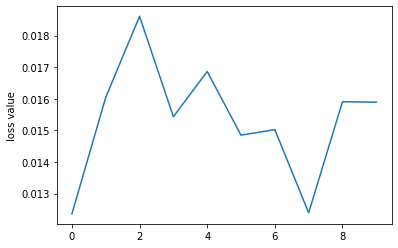

In [88]:
import matplotlib.pyplot as plt

def draw_loss_curve(x):
    plt.ylabel('loss value')
    plt.plot(x)
    plt.show()

draw_loss_curve(model.loss_rec_)

## Begin trying to find the best parameter

### No of embedding

In [111]:
def calculating_correlation(sg):
    sim=[]
    pairs = loadPairs('/content/drive/MyDrive/DSBA M2/2 NLP/exercise_1/for_final_submission/simlex.csv')
    for a, b, _ in tqdm(pairs):
        # make sure this does not raise any exception, even if a or b are not in sg.vocab
        # print(sg.similarity(a, b))
        sim.append(sg.similarity(a, b))

    pairs = loadPairs('/content/drive/MyDrive/DSBA M2/2 NLP/exercise_1/for_final_submission/simlex.csv')
    pairs_list = list(pairs)

    sim999=[pair[2] for pair in pairs_list]

    import scipy
    correlation, p_value = scipy.stats.pearsonr(sim, sim999)

    # 第一个返回的是correlation，第二个是spearman的correlatino and p value
    return correlation, list(scipy.stats.spearmanr(sim, sim999))

In [193]:
from tqdm import tqdm

nEmbed = [50, 80, 100, 150, 200, 250, 300, 1200, 1800, 2400, 3000]
result_embedding = []


for i in tqdm(nEmbed):
    temp = []
    model=SkipGram(sentences, temp, nEmbed=i, negativeRate=5, winSize=5, minCount=5, lr=0.001)
    model.train()
  
    result_embedding.append([model.for_store_parameters, model.loss_rec_, calculating_correlation(model)])

  0%|          | 0/11 [00:00<?, ?it/s]
999it [00:00, 59570.22it/s]
  9%|▉         | 1/11 [00:20<03:21, 20.12s/it]
999it [00:00, 50725.88it/s]
 18%|█▊        | 2/11 [00:32<02:19, 15.46s/it]
999it [00:00, 52864.71it/s]
 27%|██▋       | 3/11 [00:44<01:52, 14.07s/it]
999it [00:00, 56115.04it/s]
 36%|███▋      | 4/11 [00:57<01:34, 13.56s/it]
999it [00:00, 56016.01it/s]
 45%|████▌     | 5/11 [01:10<01:19, 13.25s/it]
999it [00:00, 46055.28it/s]
 55%|█████▍    | 6/11 [01:22<01:05, 13.02s/it]
999it [00:00, 39232.50it/s]
 64%|██████▎   | 7/11 [01:35<00:52, 13.02s/it]
999it [00:00, 50165.93it/s]
 73%|███████▎  | 8/11 [01:49<00:39, 13.10s/it]
999it [00:00, 58940.09it/s]
 82%|████████▏ | 9/11 [02:03<00:26, 13.38s/it]
999it [00:00, 45180.28it/s]
 91%|█████████ | 10/11 [02:17<00:13, 13.79s/it]
999it [00:00, 40471.64it/s]
100%|██████████| 11/11 [02:33<00:00, 13.93s/it]


In [189]:
def draw_many_loss_curve(x): # x should be result-list format
    plt.figure(figsize=(15, 10))
    plt.ylabel('loss value')
    x_label = np.linspace(0, 10, 10)
    for i in x:
        plt.plot(x_label, i[1], label=str(i[0][0]))
    plt.legend()
    plt.show()

def draw_correlation_coefficient(x):
    x_axis = np.linspace(0, len(x), len(x))
    plt.figure(figsize=(15, 10))
    temp = []
    for i in range(len(result)):
        temp.append(result[i][2][0])

    plt.plot(temp)
    plt.legend()
    plt.show()

In [169]:
len(result_embedding)

11

In [194]:
temp = []
for i in range(len(result_embedding)):
    temp.append(result_embedding[i][2][0])
temp

[0.080296253948573,
 0.07603699204866479,
 0.07791373134472535,
 0.07351827522325038,
 0.07498330444065798,
 0.08016073278143869,
 0.08001193377194846,
 0.08075427772760127,
 0.08060981850344964,
 0.07986163269106734,
 0.08034029410613147]

No handles with labels found to put in legend.


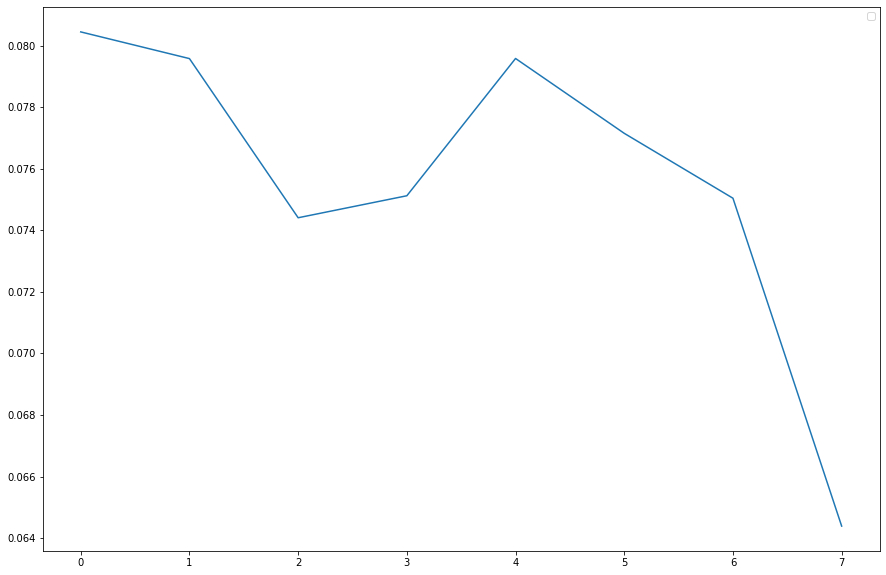

In [196]:
draw_correlation_coefficient(result_embedding)

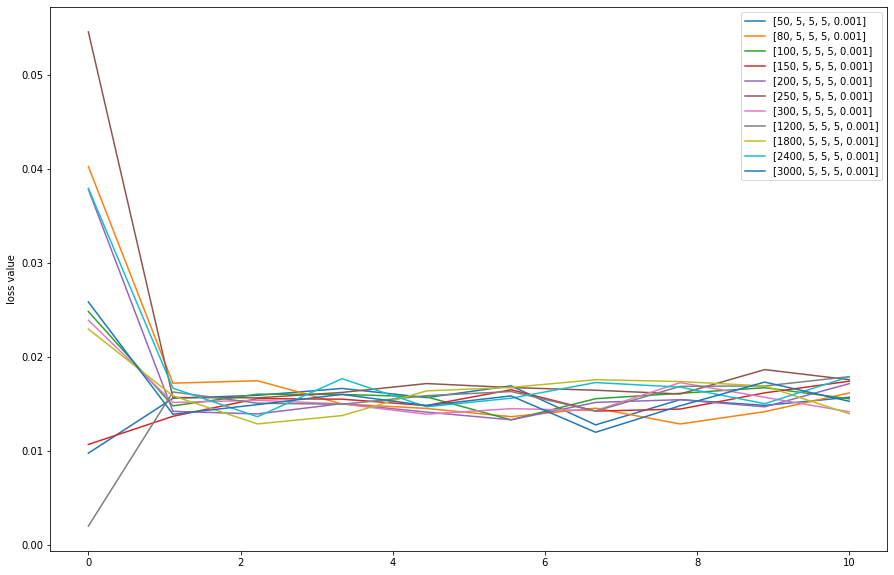

In [195]:
draw_many_loss_curve(result_embedding)

In [115]:
result[0][1]

[0.02297818803872658,
 0.013870621395235856,
 0.014291202365004066,
 0.014928763210033015,
 0.014448779617962272,
 0.01469793549516641,
 0.01598819325693943,
 0.017758720592776205,
 0.015524399545529657,
 0.01754759229046903]

In [113]:
result

[[[[300, 5, 5, 5, 0.001]],
  [0.02297818803872658,
   0.013870621395235856,
   0.014291202365004066,
   0.014928763210033015,
   0.014448779617962272,
   0.01469793549516641,
   0.01598819325693943,
   0.017758720592776205,
   0.015524399545529657,
   0.01754759229046903],
  (0.08159866995575625, [0.08454939997702975, 0.00749987794735056])],
 [[[1200, 5, 5, 5, 0.001]],
  [0.00022741654210476015,
   0.015484395766755596,
   0.015120133507178873,
   0.014147642687158587,
   0.014226499185565426,
   0.012935875306624746,
   0.013206753865745744,
   0.017383216350499348,
   0.019242500623554835,
   0.01668188146509173],
  (0.07928659656391207, [0.07711190647100442, 0.014774810738472156])],
 [[[1800, 5, 5, 5, 0.001]],
  [0.02091844927440538,
   0.01617042985626759,
   0.016982640962168713,
   0.013481550209189674,
   0.01693176679313599,
   0.01441517740996509,
   0.018493027781997472,
   0.015807901398774138,
   0.01789560851003155,
   0.016942163551549354],
  (0.07864566418475144, [0.0722

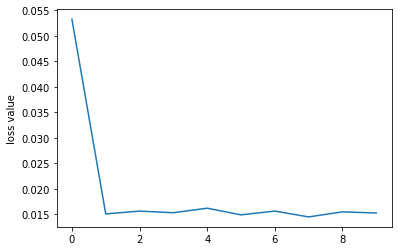

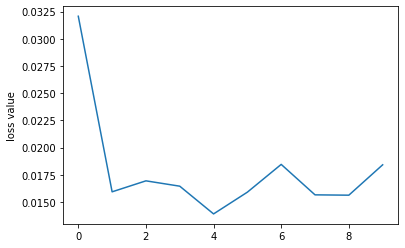

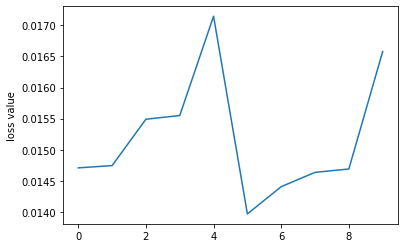

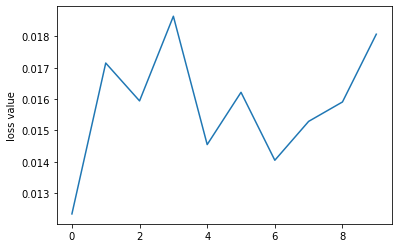

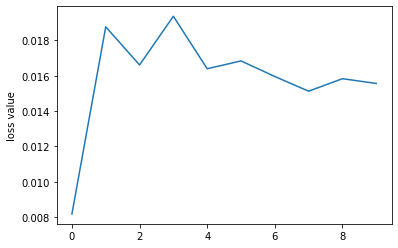

In [105]:
for i in range(len(result)):
    draw_loss_curve(result[i][1])

In [103]:
result[1][1]

[0.03206772165789229,
 0.0159371707771637,
 0.016945412045935145,
 0.016455030618956347,
 0.013906952178701177,
 0.015906409190133624,
 0.018456870172955563,
 0.015658985412395462,
 0.015628129111439733,
 0.018418828922087554]

### learning rate 

In [ ]:
from tqdm import tqdm

lr = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
result = []

for i in tqdm(lr):
    temp = []
    model=SkipGram(sentences, temp, nEmbed=300, negativeRate=5, winSize=5, minCount=5, lr=i)
    model.train()
  
    result.append([model.for_store_parameters, model.loss_rec_, calculating_correlation(model)])

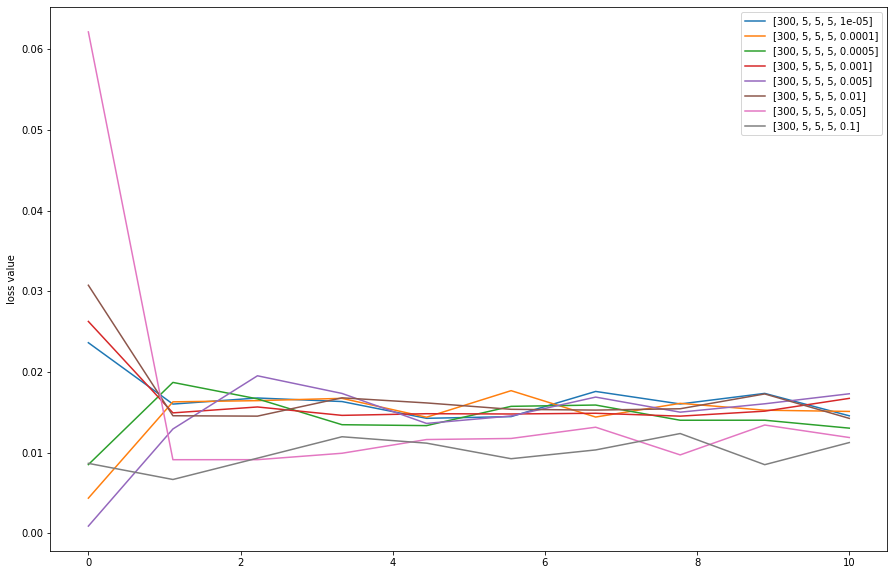

In [190]:
ndraw_many_loss_curve(result)

No handles with labels found to put in legend.


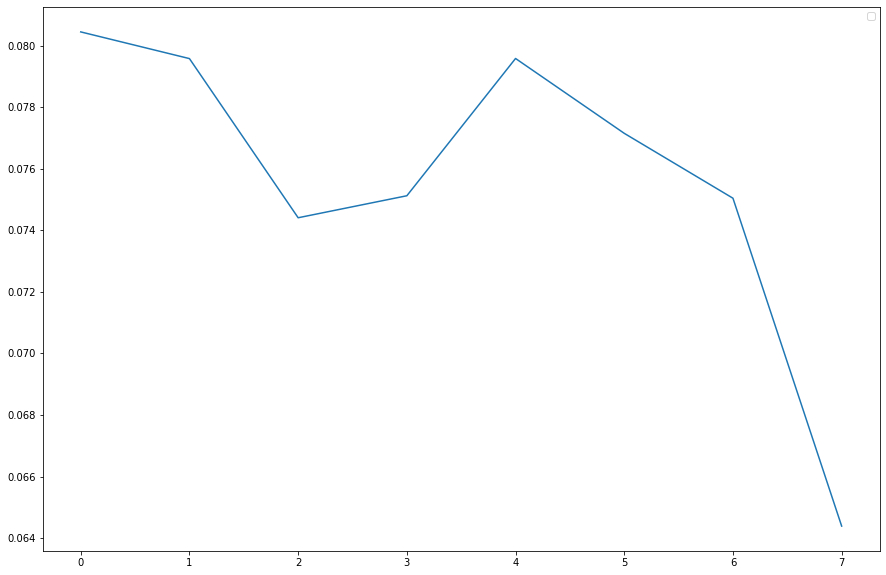

In [191]:
draw_correlation_coefficient(result)

In [228]:
def draw_many_loss_curve(x): # x should be result-list format
    label = []
    for i in range(len(x)):
        label.append(x[i][0][0][4])

    fig = plt.figure(figsize = (8, 4))
    plt.ylabel('loss value')
    x_label = np.linspace(0, 1000, 10)
    for i in range(len(x)):
        plt.plot(x_label, x[i][1], label=label[i])
    plt.legend()
    plt.show()

def draw_correlation_coefficient(x, lr_list):
    x_axis = lr_list
    fig = plt.figure(figsize = (8, 4))
    temp = []
    for i in range(len(result)):
        temp.append(result[i][2][0])

    plt.ylabel('Learning Rate')
    plt.xlabel('Correlation Coefficient')
    plt.plot(lr_list, temp)
    plt.legend()
    plt.show()

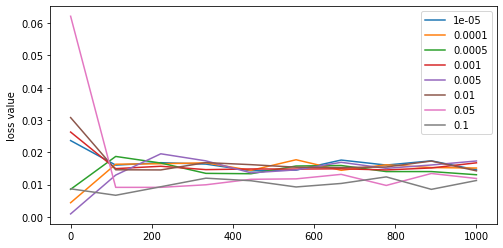

In [216]:
draw_many_loss_curve(result)

No handles with labels found to put in legend.


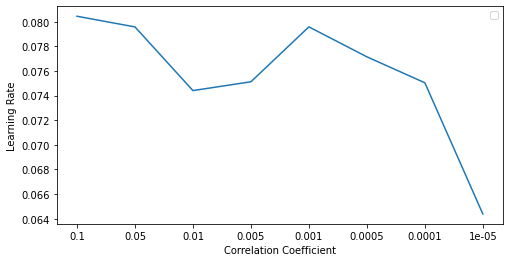

In [229]:
draw_correlation_coefficient(result, lr_list = [str(i) for i in sorted([0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1], reverse=True)])

In [ ]:
result

999it [00:00, 32745.46it/s]


(0.0806564712656048, [0.0857780204099121, 0.0066719474125378035])

test

In [83]:
pairs = loadPairs('/content/drive/MyDrive/DSBA M2/2 NLP/exercise_1/for_final_submission/simlex.csv')

In [ ]:
|# a = list(pairs)
# a[:10]

In [18]:
sg = SkipGram.load('/content/drive/MyDrive/DSBA M2/2 NLP/exercise_1/for_final_submission/mymodel_1.model')

In [40]:
from tqdm import tqdm
sim=[]

for a, b, _ in tqdm(pairs):
    # make sure this does not raise any exception, even if a or b are not in sg.vocab
    # print(sg.similarity(a, b))
    sim.append(sg.similarity(a, b))

999it [00:00, 45817.08it/s]


In [41]:
pairs = loadPairs('/content/drive/MyDrive/DSBA M2/2 NLP/exercise_1/for_final_submission/simlex.csv')
pairs_list = list(pairs)

In [42]:
sim999=[pair[2] for pair in pairs_list]

In [43]:
sim999[:4]

[1.58, 9.2, 8.77, 9.55]

In [44]:
len(sim), len(sim999)

(999, 999)

In [45]:
import scipy
correlation, p_value = scipy.stats.pearsonr(sim, sim999)

In [46]:
print(correlation)

0.08069662654576776


In [106]:
scipy.stats.spearmanr(sim, sim999)

SpearmanrResult(correlation=0.08102421859383263, pvalue=0.010409041194612846)

In [107]:
list(scipy.stats.spearmanr(sim, sim999))

[0.08102421859383263, 0.010409041194612846]